# Calibración de una Cámara con OpenCV

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/2-Percepcion/2-2-Calibracion-Camara.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt   # Para mostrar las imágenes
import glob                       # Para importar los nombres de las imágenes
import cv2

Si se usa Google Colab: descargar las imágenes (zip) y descomprimirlas. Si no se usa, se debe tener una carpeta local llamada `imagenes` donde se encuentren las imágenes.

In [2]:
colab = True
if colab:
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/2-Percepcion/imagenes.zip
    !unzip -qq imagenes.zip -d imagenes

In [3]:
# Lista de los nombres de las imágenes usadas para la calibración
image_names = glob.glob('imagenes/tablero*.jpg')

print("Número de imágenes:", len(image_names))
print("Ejemplo de imagen:", image_names[0])

Número de imágenes: 27
Ejemplo de imagen: imagenes/tablero12.jpg


## 1.&nbsp;Puntos en el objeto (índices)

La imagen (patrón) de calibración utilizada para adquirir las imágenes con la cámara que se desea calibrar se muestra a continuación.

<img src="https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/2-Percepcion/imagenes/patronReal.jpg" width="200" height="200">

Para la calibración en OpenCV son importantes solamente los puntos que determinan las intersecciones internas; es decir, aquellos puntos rodeados por dos cuadrados negros y dos cuadrados blancos. Se puede determinar que hay 8 intersecciones internas en la horizontal (eje $X$), y 6 puntos en la vertical (eye $Y$), dando un total de 48 intersecciones. A estos puntos se les denomina "puntos del objeto" ("object points") y cada uno se representará como $(X_i,Y_i,0)$, donde $X_i$, $Y_i$ son enteros que comienzan en cero. Así, a la primera intersección se le asociará el punto $(0,0,0)$, a la segunda $(1,0,0)$, y así hasta llegar al último punto $(7,5,0)$.

In [4]:
# Preparar los puntos del objeto: (0,0,0), (1,0,0), (2,0,0) ..., (7,5,0)
nx = 8; ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(nx*ny,2)

print("Primeros puntos:"); print(objp[0:4])
print("Últimos puntos:"); print(objp[-4:])

Primeros puntos:
[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]]
Últimos puntos:
[[4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]]


## 2.&nbsp;Puntos en la imagen (corners)

A continuación se muestra un ejemplo de cómo obtener los puntos correspondientes a las intersecciones internas del patrón en la imagen (llamados "corners") para una única imagen. Con este fin se utiliza la función [`findChessboardCorners`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a). Luego se utiliza la función [`cornerSubPix`](https://docs.opencv.org/4.8.0/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e) para incrementar la exactitud de estos puntos.

Tamaño de la imagen: (x,y)=(400, 300)


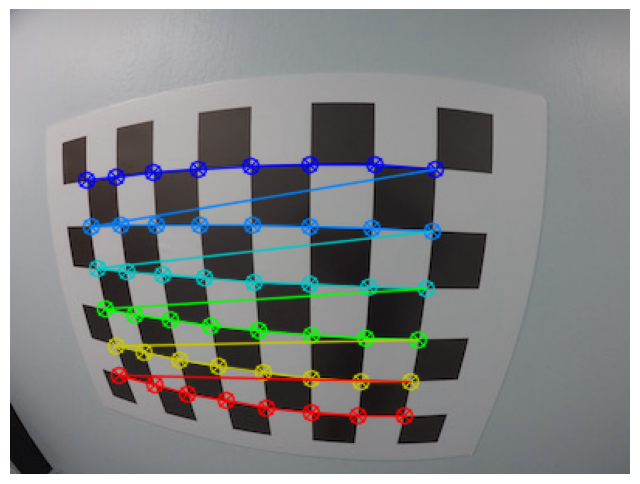

In [11]:
# Lectura de una imagen
I = cv2.imread(image_names[0])

# Tamaño de la imagen
I_size = (I.shape[1], I.shape[0])
print(f"Tamaño de la imagen: (x,y)=({I_size[0]}, {I_size[1]})")

# Conversión de la imagen a escala de grises
Igray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

# Encontrar las esquinas (corners) denominadas "puntos de la imagen" ("image points")
retval, corners = cv2.findChessboardCorners(Igray, (nx, ny), None)

# Criterio de término: epslon y máximo de iteraciones
criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Si se encuentra los puntos (corners), mostrar la imagen con los puntos
if retval == True:
    # Añadir precisión de sub-pixel
    corners2 = cv2.cornerSubPix(Igray, corners, (11,11), (-1,-1), criterio)
    # Añadir los puntos (corners) encontrados a la imagen
    cv2.drawChessboardCorners(I, (nx,ny), corners2, retval)
    # Mostrar la imagen
    plt.figure(figsize=(8,8))
    plt.imshow(I, cmap='gray')
    plt.axis('off'); plt.show()

Notar el orden en el que se encuentran los puntos: de izquierda a derecha y de arriba hacia abajo. Este orden permite prever con antelación las coordenadas de estos puntos en 3D conociendo las dimensiones de cada cuadrado.

A continuación se aplicará esta misma detección de esquinas pero ahora  a todas las imágenes del tablero, y se agregará las coordenadas de las esquinas (en píxeles) a la lista `img_points`. Igualmente, se agregará las coordenadas (índices) de los puntos a la lista `obj_points`. Debido a que se conoce el orden de los puntos, se puede prever su correspondencia en 3D (es decir, la correspondencia entre cada elemento de `img_points` con los índices `obj_points`).

In [6]:
# Almacén de puntos del objeto (índices) y puntos de la imagen (corners)
obj_points = []     # Puntos de cada objeto (3d)
img_points = []     # Puntos de cada imagen (2d)
show_images = False # Mostrar las imágenes?

# Bucle para todas las imágenes, buscando las "esquinas" (corners)
for idx, iname in enumerate(image_names):
    # Leer la imagen
    I = cv2.imread(iname)
    # Convertir a escala de grises
    Igray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    # Encontrar las esquinas (corners) internas del patrón
    retval, corners = cv2.findChessboardCorners(Igray, (nx,ny), None)

    # Si se encuentra los puntos, añadirlos a la lista
    if retval == True:
        # Incrementar la exactitud de los puntos
        corners2 = cv2.cornerSubPix(Igray, corners, (11,11), (-1,-1), criterio)
        # Puntos del objeto y puntos de la imagen, para la imagen actual
        obj_points.append(objp)
        img_points.append(corners2)

        # Añadir a la imagen los puntos (corners) encontrados
        cv2.drawChessboardCorners(I, (8,6), corners, retval)

        # Almacenar las imágenes con sus esquinas ("corners")
        # cv2.imwrite('corners'+str(idx)+'.jpg', I)

        # Mostrar la imagen
        if (show_images):
            plt.imshow(I, cmap='gray')
            plt.axis('off'); plt.show()

## 3.&nbsp;Calibración de la Cámara

La calibración de la cámara se realiza usando la función [`calibrateCamera`](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b), teniendo como entrada los puntos del objeto `obj_points`, los puntos correspondientes en la imagen `img_points`, y el tamaño de las imágenes.

In [7]:
# Calibración de la cámara dados los puntos objeto (3D) y los puntos imágen (corners) correspondientes
retval, M, coefs_dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, I_size, None, None)

In [8]:
# Mostrar los los parámetros
print("Matriz de calibración:"); print(np.round(M,3))
print("\nCoeficientes de distorsión:"); print(np.round(coefs_dist,3))

Matriz de calibración:
[[173.016   0.    203.123]
 [  0.    173.277 154.76 ]
 [  0.      0.      1.   ]]

Coeficientes de distorsión:
[[-0.22   0.054  0.    -0.    -0.006]]


El formato de la matriz de calibración es
$$
\begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1\end{bmatrix}
$$
donde las distancias focales son $(f_x,f_y)$ y los centros ópticos $(c_x,c_y)$. Los coeficientes de distorsión tienen el formato $(k_1, k_2, p_1, p_2, k_3)$, donde $k_1, k_2, k_3$ corresponden a la distorsión radial, y $p_1, p_2$ a la distorsión tangencial. La distorsión radial está expresada como $x_{dist}=x(1+k_1r^2+k_2r^4+k_3r^6)$, y, $y_{dist}=y(1+k_1r^2+k_2r^4+k_3r^6)$.

Los parámetros pueden ser almacenados en un archivo binario, usando la biblioteca llamada `pickle`, para luego ser cargados cuando sea necesario. Los parámetros calibrados se almacenarán en formato de diccionario (pero en binario) en el archivo `camera_params.p`.

In [9]:
# Grabar los valores usando pickle
import pickle

# Diccionario para almacenar parámetros calibrados
params = {}
params["M"] = M
params["coefs_dist"] = coefs_dist

# Almacenar los parámetros de la cámara
pickle.dump(params, open("camera_params.p", "wb"))

Para quitar la distorsión a una imagen, se puede cargar la imagen y luego aplicar la función [undistort](https://docs.opencv.org/4.8.0/d9/d0c/group__calib3d.html#ga69f2545a8b62a6b0fc2ee060dc30559d).

## 4.&nbsp;Aplicación de la Calibración a una Imagen

Los parámetros intrínsecos obtenidos durante la calibración de la cámara pueden ser obtenidos para quitar la distorsión a una imagen. Con este fin se utiliza la función `cv2.undistort`.

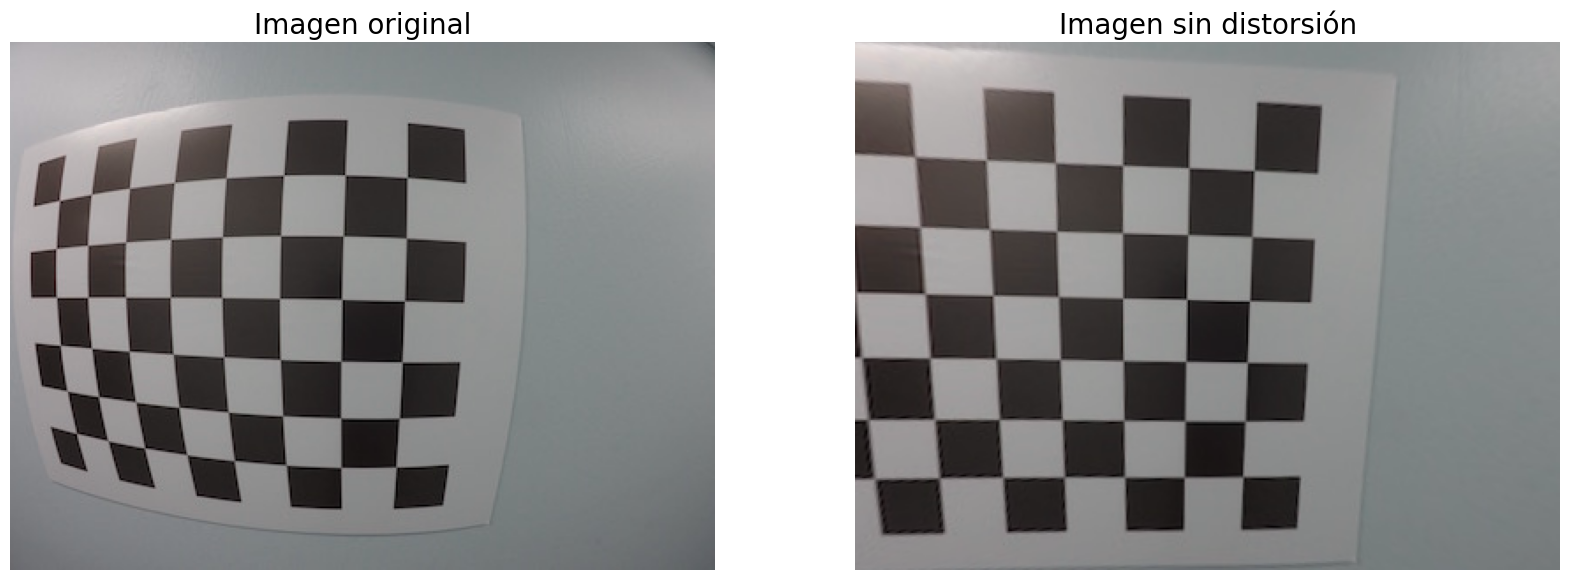

In [10]:
# Imagen de entrada
Iorig = cv2.imread('imagenes/tablero10.jpg')

# Corregir la distorsión
Iundist = cv2.undistort(Iorig, M, coefs_dist, None)

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(Iorig)
ax1.set_title('Imagen original', fontsize=20); ax1.axis('off')
ax2.imshow(Iundist)
ax2.set_title('Imagen sin distorsión', fontsize=20); ax2.axis('off');

Nota: Al utilizar Google Colab, la función `cv2.imshow`, nativa de OpenCV, no funciona, ya que no puede abrirse una nueva ventana. Por este motivo, resulta más general utilizar  `plt.imshow` de `matplotlib.pyplot` para mostrar las imágenes. Una alternativa, en Google Colab, es importar `from google.colab.patches import cv2_imshow` y mostrar la imagen con `cv2_imshow(Imagen)`